# Numerical solution for the perceptron Channel

This is simple code in Julia that solve the optimization problem for the Perceptron problem when $y=\rm{sign}(\Phi x)$

First we import useful packages

In [37]:
#### import Pytlot (for ploting) and Cubature (for numerical integral)
using PyPlot
using Cubature
%matplotlib inline

The analogue of IPython's `%matplotlib` in Julia is to use the [PyPlot package](https://github.com/stevengj/PyPlot.jl), which gives a Julia interface to Matplotlib including inline plots in IJulia notebooks.   (The equivalent of `numpy` is already loaded by default in Julia.)

Given PyPlot, the analogue of `%matplotlib inline` is `using PyPlot`, since PyPlot defaults to inline plots in IJulia.

To enable separate GUI windows in PyPlot, analogous to `%matplotlib`, do `using PyPlot; pygui(true)`.   To specify a particular gui backend, analogous to `%matplotlib gui`, you can either do `using PyPlot; pygui(:gui); using PyPlot; pygui(true)` (where `gui` is `wx`, `qt`, `tk`, or `gtk`), or you can do `ENV["MPLBACKEND"]=backend; using PyPlot; pygui(true)` (where `backend` is the name of a Matplotlib backend, like `tkagg`).

For more options, see the PyPlot documentation.


Now we code simple routine for the iterative solution of the problem

In [30]:
function compute_MSE_range_alpha(rhoX,rangealpha,f_x,theta=0)
    valMSEX=zeros(size(rangealpha,1));
    valM=zeros(size(rangealpha,1));
    valt=zeros(size(rangealpha,1));
    valdiff=zeros(size(rangealpha,1));
    valgen=zeros(size(rangealpha,1));
    mxstart=0.01;

    for j=1:size(rangealpha,1)
        MSEX,M,t,yesorno,gen=perform_DE(mxstart,rhoX,rangealpha[j],f_x,theta);
        valMSEX[j]=MSEX;
        valM[j]=M;
        valt[j]=t;
        valdiff[j]=yesorno;
        valgen[j]=gen
        mxstart=M;
    end
    return valMSEX,valM,valt,valdiff,valgen;
end 


function perform_DE(mxstart,rhoX,alpha,f_x,theta=0,criterion=1e-6,tmax=1000)
    #First compute Z02 and init values
    Z02=rhoX;
    mx=mxstart-1e-6;
   
    diff=1;t=0;
    #@printf("t  mx      hat        MSEX     \n");
    mhat=0;
    while ((diff>criterion)&&(t<tmax))
        mhat=new_mhat(mx,Z02,theta);
        t=t+1;
        mx_new=0.5*new_mx(mhat,alpha,rhoX,f_x)+0.5*mx;
        diff=abs(mx_new-mx);
        mx=copy(mx_new);
        if (abs(Z02-mx)<criterion) break;
        end
    end
    fnrg1=free_energy(mx,mhat,rhoX,alpha,theta);
    fnrg2=free_energy_partA(rhoX,rhoX,alpha,theta)-log(2);
    @printf("%f %d %f %f %e %f %f %f %d %f  \n",alpha,t,mx,mhat,Z02-mx,theta,fnrg1,fnrg2,fnrg1>fnrg2,generalization(mx,rhoX))
    return Z02-mx,mx,t,fnrg1>fnrg2,generalization(mx,rhoX); 
end

# Iteration procedure: define new_mx,new_mhat

function new_mx(mhat,alpha,rhoX,f_x)

#    @printf("ALPHA AND MHAT->>> %f  %f \n",alpha,mhat);
    gauss_(x)=exp(-x.^2/2)/sqrt(2*pi);
    
    f(x)=gauss_(x).*(f_x(1./(alpha*mhat),-1+x./sqrt((alpha*mhat)),rhoX)).^2;
    (int1,err1)=quadgk(f,-10,10);
    g(x)=gauss_(x).*(f_x(1./(alpha*mhat),1+x./sqrt(alpha*mhat),rhoX)).^2;
    (int2,err2)=quadgk(g,-10,10);
    if (rhoX<0.999)
        h(x)=gauss_(x).*(f_x(1./(alpha*mhat),x./sqrt(alpha*mhat),rhoX)).^2;
        (int3,err3)=quadgk(h,-10,10);
    else
        int3=0;
    end
    return 0.5*(rhoX).*int1+0.5*(rhoX).*int2+(1-rhoX).*int3;
end


function H_(x)
    return 0.5*erfc(x/sqrt(2));
end	 

function gout(w,Y,V,theta)
    DELTA=0.00001;#regularization
    return (2*Y-1).*exp(-0.5*((w-theta).^2.0./(DELTA+V)))./(1e-10+sqrt(2*pi.*(DELTA+V)).*H_(-(2.*Y-1).*(w-theta)./sqrt(DELTA+V)));
end

function dgout(w,Y,V,theta)
    DELTA=0.00001;#regularization
    g=gout(w,Y,V,theta);
    return -max(g.*((w-theta)./(DELTA+V)+g),1e-10);
end

function new_mhat(mx,Z02,theta)
    gauss_(x)=exp(-x.^2/2)/sqrt(2*pi);
    f(x)=gauss_(x).*dgout(x.*sqrt(mx),0,Z02-mx,theta).*erfc(  (x.*sqrt(mx)-theta)  ./sqrt(2*(Z02-mx)) )*0.5;
    (int1,err1)=quadgk(f,-10,10);
    g(x)=gauss_(x).*dgout(x.*sqrt(mx),1,Z02-mx,theta).*erfc(  (theta-x.*sqrt(mx))./sqrt(2*(Z02-mx)) )*0.5;
    (int2,err2)=quadgk(g,-10,10);
    return -(int1+int2);
end

function H_(x)
    return 0.5*erfc(x/sqrt(2));
end	 

function free_energy_partA(mx,rho,alpha,kappa)
    if mx<1e-6
        mx=1e-3
    end
    V=rho-mx
    if (V<1e-6)
        V=1e-6
    end

    gauss_(x)=exp(-x.^2/2)/sqrt(2*pi);

    f(x)=gauss_(x)*H_((x*sqrt(mx)-kappa)/sqrt(V))*log(1e-8+H_((x*sqrt(mx)-kappa)/sqrt(V)));
    (int1,err1)=quadgk(f,-10,10);

    g(x)=gauss_(x)*H_((-x*sqrt(mx)+kappa)/sqrt(V))*log(1e-8+H_((-x*sqrt(mx)+kappa)/sqrt(V)));
    (int2,err2)=quadgk(g,-10,10);

    return alpha*(int1+int2);
end


function free_energy_partB(mhat,rho)
    gauss_(x)=exp(-x.^2/2)/sqrt(2*pi);
    f(x)=gauss_(x).*cosh(x*sqrt(mhat))*(logcosh(x*sqrt(mhat))-0.5*mhat)*exp(-mhat./2);
    (int1,err1)=quadgk(f,-10,10);
    return int1;
end

function logcosh(x)
    if x>0
        return x-log(2)+log1p(exp(-2*x));
    else
        return -x-log(2)+log1p(exp(2*x));
    end
end


function generalization(mx,rho)
    if mx<1e-6
        mx=1e-3
    end
    V=rho-mx
    if (V<1e-6)
        V=1e-6
    end

    gauss_(x)=exp(-x.^2/2)/sqrt(2*pi);
    f(x)=gauss_(x)*erf(x*sqrt(mx/(2*V))).^2;
    (int1,err1)=quadgk(f,-10,10);
    return 1-int1;
end


function free_energy(mx,mhat,rho,alpha,kappa)
    return  free_energy_partA(mx,rho,alpha,kappa)+free_energy_partB(alpha*mhat,rho)-0.5*mx*mhat*alpha;
end



function f_plusminus(Sigma,R,rho,plus=1,minus=-1)
    pz=(1-rho)*exp(-0.5*(R).^2./Sigma);
    pp=0.5*(rho)*exp(-0.5*(R-plus).^2./Sigma);
    pm=0.5*(rho)*exp(-0.5*(R-minus).^2./Sigma);
    m=(pp*(plus)+pm*(minus))./(pz+pp+pm+1e-20);
    m2=(pp*(plus.^2)+pm*(minus.^2))./(pz+pp+pm+1e-20);
    return m,max(m2-m.*m,1e-20);
end
#
####

f_plusminus (generic function with 3 methods)

Now, we can directly call the function...

In [46]:
f_x(x,y,z)=f_plusminus(x,y,z)[1]
theta=0;
rhoX=1;

rangealpha=0.01:0.001:1.6
X,M,T,F,G=compute_MSE_range_alpha(rhoX,rangealpha,f_x,theta);

0.010000 12 0.006352 0.639200 9.936475e-01 0.000000 -0.006921 -0.693147 1 0.995956  
0.011000 10 0.006984 0.639458 9.930155e-01 0.000000 -0.007612 -0.693147 1 0.995554  
0.012000 10 0.007618 0.639717 9.923822e-01 0.000000 -0.008303 -0.693147 1 0.995150  
0.013000 10 0.008251 0.639976 9.917492e-01 0.000000 -0.008994 -0.693147 1 0.994747  
0.014000 10 0.008883 0.640236 9.911165e-01 0.000000 -0.009684 -0.693147 1 0.994345  
0.015000 10 0.009516 0.640495 9.904841e-01 0.000000 -0.010374 -0.693147 1 0.993942  
0.016000 10 0.010148 0.640755 9.898519e-01 0.000000 -0.011064 -0.693147 1 0.993539  
0.017000 10 0.010780 0.641015 9.892201e-01 0.000000 -0.011754 -0.693147 1 0.993137  
0.018000 10 0.011412 0.641275 9.885885e-01 0.000000 -0.012444 -0.693147 1 0.992735  
0

.042000 10 0.012043 0.641535 9.879571e-01 0.000000 -0.013133 -0.693147 1 0.992333  
0.020000 10 0.012674 0.641795 9.873261e-01 0.000000 -0.013822 -0.693147 1 0.991931  
0.021000 10 0.013305 0.642056 9.866953e-01 0.000000 -0.014511 -0.693147 1 0.991530  
0.022000 10 0.013935 0.642316 9.860649e-01 0.000000 -0.015200 -0.693147 1 0.991128  
0.023000 10 0.014565 0.642577 9.854346e-01 0.000000 -0.015889 -0.693147 1 0.990727  
0.024000 10 0.015195 0.642837 9.848047e-01 0.000000 -0.016577 -0.693147 1 0.990326  
0.025000 10 0.015825 0.643098 9.841750e-01 0.000000 -0.017265 -0.693147 1 0.989925  
0.026000 10 0.016454 0.643359 9.835457e-01 0.000000 -0.017953 -0.693147 1 0.989524  
0.027000 10 0.017083 0.643620 9.829165e-01 0.000000 -0.018641 -0.693147 1 0.989124  
0.028000 10 0.017712 0.643881 9.822877e-01 0.000000 -0.019329 -0.693147 1 0.988723  
0.029000 10 0.018341 0.644142 9.816591e-01 0.000000 -0.020016 -0.693147 1 0.988323  
0.030000 10 0.018969 0.644404 9.810308e-01 0.000000 -0.020703 -0.6

... and plot the result for the learning error:

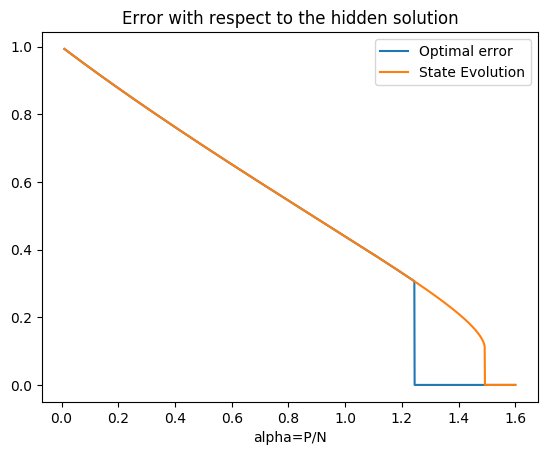

PyObject <matplotlib.legend.Legend object at 0x32ac70ad0>

In [56]:
p=plot(rangealpha,X.*F,label="Optimal error")
plot(rangealpha,X,label="State Evolution")
title("Error with respect to the hidden solution")
xlabel("alpha=P/N")
legend(loc="upper right",fancybox="true")

as well as for the generalization error

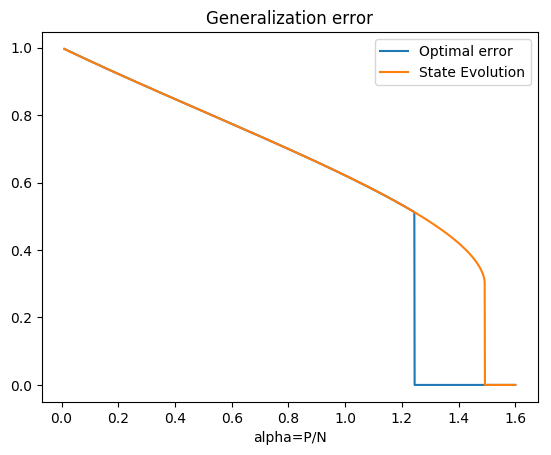

PyObject <matplotlib.legend.Legend object at 0x32b01a9d0>

In [57]:
p=plot(rangealpha,G.*F,label="Optimal error")
plot(rangealpha,G,label="State Evolution")
title("Generalization error")
xlabel("alpha=P/N")
legend(loc="upper right",fancybox="true")